In [1]:
import pandas as pd

In [21]:
cen = pd.read_csv('../data/processed/censimento.csv')
mc = pd.read_excel('/Users/navid/Documents/1_Projects/0_Age-It/Our Tasks/Mario_report/data/MassaCritica.xlsx')
ssd_map = pd.read_excel('/Users/navid/Documents/1_Projects/0_Age-It/Our Tasks/Mario_report/data/SSD_V3_area.xlsx')


In [4]:
mc.head(3)

,Codice,Soggetto,CUP,Nome,Cognome,Codice fiscale,Inquadramento contrattuale,Impegno contrattuale,Modalità di rendicontazione,Livello,Costo orario €,Ruolo ricoperto
0,PE_00000015,Consiglio Nazionale delle Ricerche - CNR,B83C22004880006,Daniela,Trisciuoglio,TRSDNL73R55H501N,Ricercatore,tempo pieno,Rendicontazione a costi standard,ALTO - EPR,NaN,Spoke
1,PE_00000015,Consiglio Nazionale delle Ricerche - CNR,B83C22004880006,Tiziana,Tesauro,TSRTZN71H58F205V,Ricercatore (III livello),tempo pieno,Rendicontazione a costi standard,MEDIO - EPR,NaN,Affiliato
2,PE_00000015,Consiglio Nazionale delle Ricerche - CNR,B83C22004880006,Pietro,Siciliano,SCLPRL60D26I549H,"Dirigente di Ricerca, I Livello",tempo pieno,Rendicontazione a costi standard,ALTO - EPR,NaN,Affiliato


In [7]:
cen.head()

,Nome,Cognome,Codice fiscale,SSD,Email,age
0,Daniela,Trisciuoglio,TRSDNL73R55H501N,BIOS-10/A,daniela.trisciuoglio@cnr.it,53
1,Serena,Sanna,SNNSRN80S55H856X,BIOS-04/A,serena.sanna@cnr.it,46
2,Francesca,Cavalcanti,CVLFNC61T56D086E,BIOS-11/A,francesca.cavalcanti@irib.cnr.it,65
3,Paolo,Barsocchi,BRSPLA78S27G702C,INFO-01/A,paolo.barsocchi@isti.cnr.it,48
4,Antonino,Colanzi,CLNNNN64B29E435X,BIOS-10/A,antonino.colanzi@cnr.it,62


In [9]:
mc = pd.merge(mc, cen[['Codice fiscale', 'SSD']], on='Codice fiscale', how='left')

In [10]:
mc.head(3)

,Codice,Soggetto,CUP,Nome,Cognome,Codice fiscale,Inquadramento contrattuale,Impegno contrattuale,Modalità di rendicontazione,Livello,Costo orario €,Ruolo ricoperto,SSD
0,PE_00000015,Consiglio Nazionale delle Ricerche - CNR,B83C22004880006,Daniela,Trisciuoglio,TRSDNL73R55H501N,Ricercatore,tempo pieno,Rendicontazione a costi standard,ALTO - EPR,NaN,Spoke,BIOS-10/A
1,PE_00000015,Consiglio Nazionale delle Ricerche - CNR,B83C22004880006,Tiziana,Tesauro,TSRTZN71H58F205V,Ricercatore (III livello),tempo pieno,Rendicontazione a costi standard,MEDIO - EPR,NaN,Affiliato,NaN
2,PE_00000015,Consiglio Nazionale delle Ricerche - CNR,B83C22004880006,Pietro,Siciliano,SCLPRL60D26I549H,"Dirigente di Ricerca, I Livello",tempo pieno,Rendicontazione a costi standard,ALTO - EPR,NaN,Affiliato,NaN


In [5]:
import re
import requests
from bs4 import BeautifulSoup


DOCENTI_URL_DEFAULT = (
    "https://cercauniversita.mur.gov.it/php5/docenti/vis_docenti.php?docinput={}&docsubmit=cerca"
)
ASSEGNASTI_URL_DEFAULT = (
    "https://cercauniversita.mur.gov.it/php5/assegnisti/vis_assegnisti.php?"
    "qualifica=**&argomento=&title_radiogroup=P&cognome={}&nome={}&radiogroup=E&universita=00&facolta=00&"
    "settore=0000&area=0000&situazione_al=0&vai=Invio"
)


def fetch_ssd(
    first_name: str,
    last_name: str,
    *,
    timeout: int = 10,
    session: requests.Session | None = None,
    docenti_url_template: str = DOCENTI_URL_DEFAULT,
    assegnisti_url_template: str = ASSEGNASTI_URL_DEFAULT,
) -> str:
    """
    Fetch SSD by querying first DOCENTI (by last_name), then ASSEGNASTI (by last_name + first_name).

    Returns:
        - SSD string if found
        - "NULL" otherwise
    """

    def _extract_ssd_from_url(url: str) -> str:
        try:
            s = session or requests
            resp = s.get(url, timeout=timeout)
            resp.raise_for_status()
        except requests.RequestException:
            return "NULL"

        soup = BeautifulSoup(resp.text, "html.parser")
        table = soup.find("table", {"class": "risultati"})
        if not table:
            return "NULL"

        rows = table.find_all("tr")[1:]  # skip header row
        for row in rows:
            cols = row.find_all("td")
            if len(cols) >= 7:
                ssd_2024 = cols[5].get_text(strip=True)
                department = cols[6].get_text(strip=True)

                # Your original logic: if SSD looks like a department name (some assegnisti), return department
                if re.search(r"\(\w+\)", ssd_2024):
                    return department

                return ssd_2024

        return "NULL"

    # Normalise inputs a bit
    first_name = (first_name or "").strip()
    last_name = (last_name or "").strip()

    if not last_name:
        return "NULL"

    # 1) DOCENTI lookup (only last name in your current URL design)
    ssd_value = _extract_ssd_from_url(docenti_url_template.format(last_name))

    # 2) ASSEGNASTI fallback (requires both last + first name)
    if ssd_value == "NULL" and first_name:
        ssd_value = _extract_ssd_from_url(assegnisti_url_template.format(last_name, first_name))

    return ssd_value

In [12]:
import requests

# Reuse one session (faster + nicer to the remote server)
sess = requests.Session()

col = "SSD"  # <-- your column name (or use "ssd" if that's the one you want to fill)

mask = mc[col].isna() | (mc[col].astype(str).str.strip().str.upper() == "NULL")

mc.loc[mask, col] = mc.loc[mask].apply(
    lambda row: fetch_ssd(row["Nome"], row["Cognome"], session=sess),
    axis=1,
)

In [16]:
mc['SSD'] = mc.SSD.dropna()

In [19]:
ssd = mc[['SSD']]

In [22]:
ssd.head()

,SSD
0,BIOS-10/A
1,12/GIUR-14
2,06/MEDS-16
3,BIOS-04/A
4,10/FRAN-01


In [23]:
ssd_map.head()

,Cod. SSD,Area,Area_desc
0,MATH-01/A,AREA 01,SCIENZE MATEMATICHE E INFORMATICHE
1,MATH-01/B,AREA 01,SCIENZE MATEMATICHE E INFORMATICHE
2,MATH-02/A,AREA 01,SCIENZE MATEMATICHE E INFORMATICHE
3,MATH-02/B,AREA 01,SCIENZE MATEMATICHE E INFORMATICHE
4,MATH-03/A,AREA 01,SCIENZE MATEMATICHE E INFORMATICHE


In [27]:
ssd = pd.merge(ssd, ssd_map, left_on='SSD', right_on='Cod. SSD', how='left')

In [28]:
ssd

,SSD,Cod. SSD,Area,Area_desc
0,BIOS-10/A,BIOS-10/A,AREA 05,SCIENZE BIOLOGICHE
1,12/GIUR-14,NaN,NaN,NaN
2,06/MEDS-16,NaN,NaN,NaN
3,BIOS-04/A,BIOS-04/A,AREA 05,SCIENZE BIOLOGICHE
4,10/FRAN-01,NaN,NaN,NaN
...,...,...,...,...
375,BIOS-14/A,BIOS-14/A,AREA 05,SCIENZE BIOLOGICHE
376,11/PAED-01,NaN,NaN,NaN
377,MEDS-05/A,MEDS-05/A,AREA 06,SCIENZE MEDICHE
378,MEDS-05/A,MEDS-05/A,AREA 06,SCIENZE MEDICHE


In [30]:
ssd.dropna(subset=['Area_desc'], inplace=True)

In [31]:
ssd['Area_desc'].value_counts()

Area_desc
SCIENZE ECONOMICHE E STATISTICHE                                       59
SCIENZE MEDICHE                                                        52
SCIENZE BIOLOGICHE                                                     28
INGEGNERIA INDUSTRIALE E DELL'INFORMAZIONE                             23
SCIENZE POLITICHE E SOCIALI                                            22
SCIENZE STORICHE, FILOSOFICHE, PEDAGOGICHE E PSICOLOGICHE              21
 SCIENZE MATEMATICHE E INFORMATICHE                                     8
SCIENZE GIURIDICHE                                                      8
INGEGNERIA CIVILE E ARCHITETTURA                                        5
SCIENZE FISICHE                                                         2
SCIENZE CHIMICHE                                                        2
SCIENZE DELL’ANTICHITÀ, FILOLOGICO-LETTERARIE E STORICO-ARTISTICHE      1
Name: count, dtype: int64

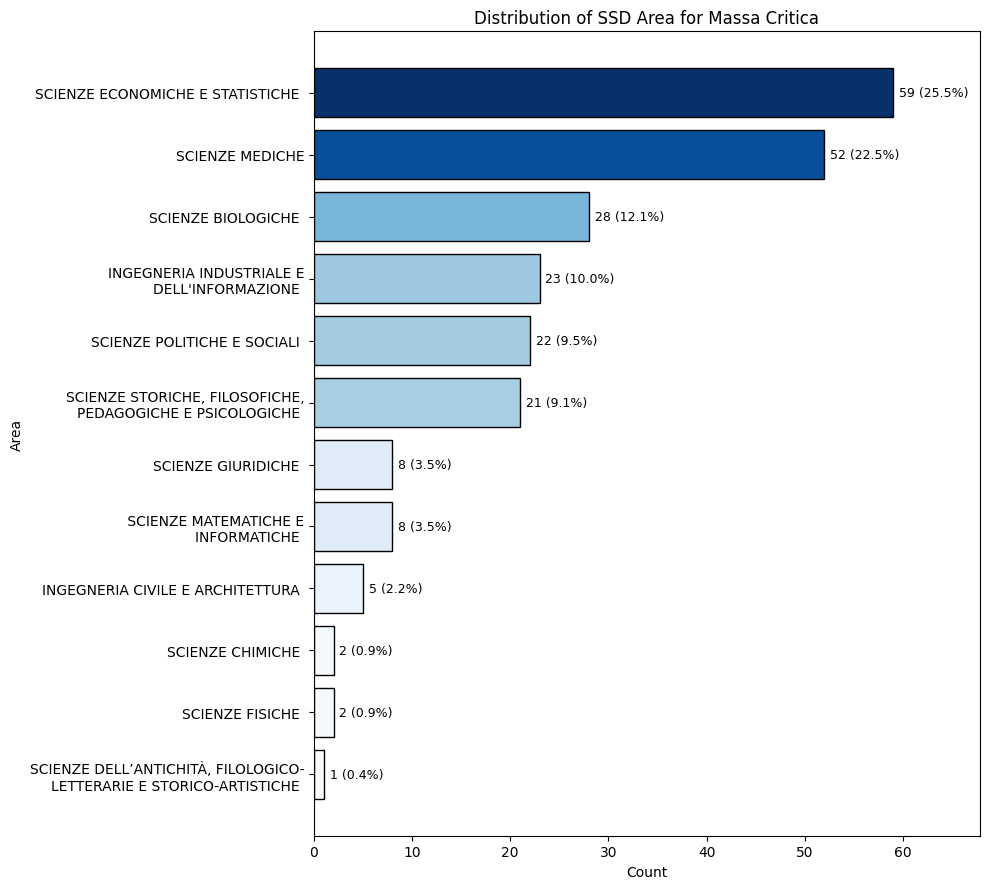

In [43]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from textwrap import fill

counts = ssd["Area_desc"].value_counts().sort_values(ascending=True)
total = counts.sum()

labels = [fill(str(x), width=35) for x in counts.index]

# Light → dark blue gradient
norm = mcolors.Normalize(vmin=counts.min(), vmax=counts.max())
cmap = cm.Blues
colors = cmap(norm(counts.values))

fig, ax = plt.subplots(figsize=(10, 6 + 0.25 * len(counts)))
ax.barh(labels, counts.values, color=colors, ec='k')

ax.set_title("Distribution of SSD Area for Massa Critica")
ax.set_xlabel("Count")
ax.set_ylabel("Area")

# count + percentage labels
x_pad = max(counts.values) * 0.01
for y, v in enumerate(counts.values):
    pct = 100 * v / total
    ax.text(v + x_pad, y, f"{v} ({pct:.1f}%)", va="center", fontsize=9)

# colourbar for reference
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, pad=0.02)
# cbar.set_label("Count (light → dark blue)")

ax.margins(x=0.15)
plt.tight_layout()
plt.show()